In [43]:
from PIL import Image
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [57]:
tab20b = plt.cm.tab20b
tab20b_c = tab20b(np.linspace(0, 1, 115))
np.random.shuffle(tab20b_c)
new = np.vstack(([[1, 1, 1, 0]], tab20b_c))
tab20b_2 = mcolors.ListedColormap(new)

In [131]:
def get_tif_path(year):
    ext = "simVIIRS.tif" if year > 2013 else "calDMSP.tif"
    return f"./data/raw/Harmonized_DN_NTL_{year}_{ext}"

usa = gpd.read_file("./data/us-states.json")

continental_states = usa[~usa['name'].isin(['Alaska', 'Hawaii', 'Guam', 'Commonwealth of the Northern Mariana Islands', 'United States Virgin Islands', 'American Samoa', 'District of Columbia', 'Puerto Rico'])]
continental_states.head()

,id,name,density,geometry
0,01,Alabama,94.65,"POLYGON ((-87.3593 35.00118, -85.60668 34.9847..."
2,04,Arizona,57.05,"POLYGON ((-109.0425 37.00026, -109.04798 31.33..."
3,05,Arkansas,56.43,"POLYGON ((-94.47384 36.50186, -90.15254 36.496..."
4,06,California,241.70,"POLYGON ((-123.23326 42.00619, -122.37885 42.0..."
5,08,Colorado,49.33,"POLYGON ((-107.91973 41.00391, -105.72895 40.9..."


In [132]:
mass = continental_states[continental_states['name'] == 'Massachusetts']
mass

,id,name,density,geometry
21,25,Massachusetts,840.2,"POLYGON ((-70.91752 42.88797, -70.81894 42.871..."


In [47]:
for year in range(1992, 2019):

    with rasterio.open(get_tif_path(year)) as src:
        mass = mass.to_crs(src.crs)

        geoms = mass.geometry.values

        out_image, out_transform = mask(src, geoms, crop=True)
        out_meta = src.meta.copy()

    out_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    with rasterio.open(f"./data/processed/MA_{year}.tif", "w", **out_meta) as dest:
        dest.write(out_image)

In [48]:
image = Image.open("./data/processed/MA_2018.tif")
image.show()
image.close()

In [133]:
with rasterio.open('./data/processed/MA_2018.tif') as src:
    night_lights = src.read(1)
    np.nan_to_num(night_lights, nan=0)
    transform = src.transform
    crs = src.crs

threshold = 55
binary_lights = (night_lights > threshold).astype(np.uint64)
t = night_lights.shape[0] * night_lights.shape[1]
print(sum(sum(binary_lights)))
print(sum(sum(binary_lights))/t)

5012
0.0693798449612403


In [14]:
# Get pixel coordinates where light is above threshold
y_indices, x_indices = np.where(binary_lights == 1)
# Convert pixel indices to geographic coordinates
xs, ys = rasterio.transform.xy(transform, y_indices, x_indices)
coords = np.vstack((xs, ys)).T
# Cluster
db = DBSCAN(eps=0.15, min_samples=500).fit(coords)  # tune eps and min_samples

labels = db.labels_
len(labels[labels > -1])

3118

In [50]:
interstates = gpd.read_file('./data/interstates.geojson')
interstates = interstates[interstates['name'].isin(['I- 95'])]
interstates

,name,geometry
216,I- 95,"MULTILINESTRING ((-76.52969 39.32326, -76.4979..."


In [51]:
np.unique(labels)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111])

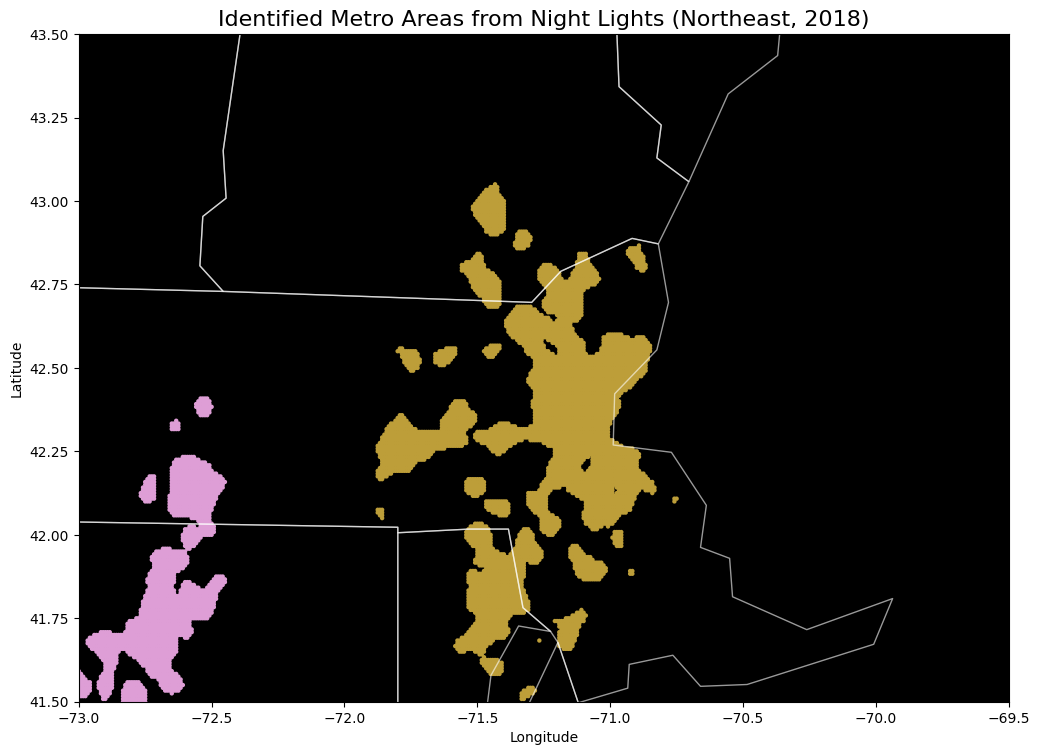

In [52]:
interstates = gpd.read_file('./data/interstates.geojson')

fig, ax = plt.subplots(figsize=(12, 12))

cont_states.boundary.plot(ax=ax, color='white', linewidth=1, alpha=0.6)

# interstates_mesh = interstates.to_crs(cont_states.crs)
# interstates_mesh.plot(ax=ax, color='red', linewidth=1, alpha=0.75)

plt.scatter(coords[:, 0], coords[:, 1], c=labels, cmap=tab20b_2, s=10, edgecolors='none')
# plt.scatter(-71.259742, 42.365664, c='red', s=20) # red dot at Brandeis

ax.set_xlim([-73, -69.5])
ax.set_ylim([41.5, 43.5])

ax.set_title("Identified Metro Areas from Night Lights (Northeast, 2018)", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_facecolor('black')
plt.grid(False)


plt.show()

In [134]:
from scipy.spatial.distance import cdist

def plot_map(year_, labels_, coords_):

    fig, ax = plt.subplots(figsize=(12, 12))

    continental_states.boundary.plot(ax=ax, color='white', linewidth=1, alpha=0.3)

    mapped_labels = np.vectorize(mapping.get)(labels_)
    plt.scatter(coords_[:, 0], coords_[:, 1], c=mapped_labels, cmap=tab20b_2, s=1, edgecolors='none')

    ax.set_title(f"Identified Metro Areas from Night Lights (US, {year_})", fontsize=16)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_facecolor('black')
    plt.grid(False)


    plt.savefig(f"figures/output_{year_}.png", dpi=300, bbox_inches='tight')
    plt.close()

def compute_centroid(points):
    """
    Compute centroid (mean longitude, mean latitude) of a cluster.
    Input: points - Nx2 array or list of (lon, lat) coordinates
    Output: tuple (lon_mean, lat_mean)
    """
    points = np.asarray(points)
    return points.mean(axis=0)

def assign_master_ids(clusters, reference_centroids):
    """
    Assign each cluster the ID of its closest reference cluster.
    
    Inputs:
    - clusters: dict {cluster_label: Nx2 array of points}
    - reference_centroids: dict {master_id: (lon, lat)}
    
    Output:
    - dict {cluster_label: assigned_master_id}
    """

    # Prepare reference centroids
    ref_ids = list(reference_centroids.keys())
    ref_points = np.array([reference_centroids[mid] for mid in ref_ids])

    assigned_ids = {}
    
    for label, points in clusters.items():
        centroid = compute_centroid(points).reshape(1, -1)
        distances = cdist(centroid, ref_points)  # shape (1, n_refs)
        closest_idx = np.argmin(distances)
        assigned_master_id = ref_ids[closest_idx]
        assigned_ids[label] = assigned_master_id
    
    return assigned_ids

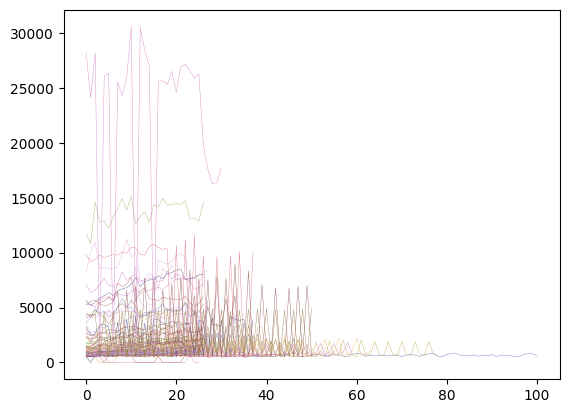

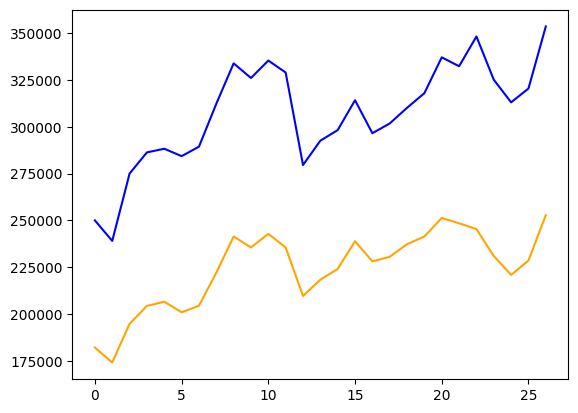

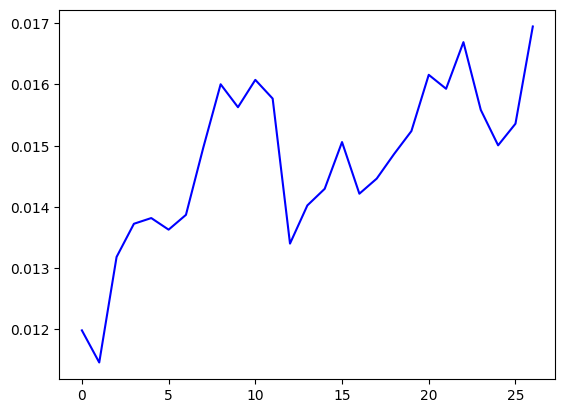

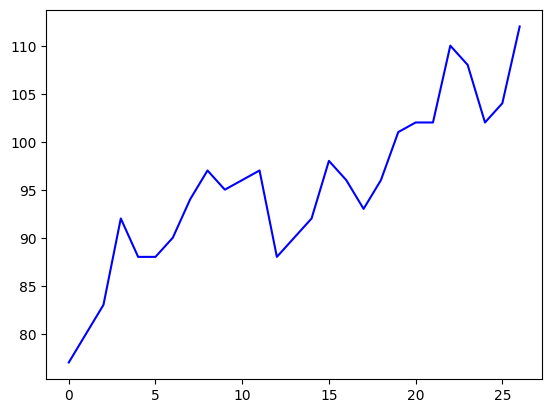

In [141]:
total_lights = []
total_in_clusters = []
percent_lights = []
num_clusters = []
sizes = {}
n = 0

for year in range(1992, 2019):
    with rasterio.open(f'./data/processed/US_{year}.tif') as src:
        night_lights = src.read(1)
        np.nan_to_num(night_lights, nan=0)
        transform = src.transform
        crs = src.crs

    threshold = 53
    binary_lights = (night_lights > threshold).astype(np.uint64)
    t = night_lights.shape[0] * night_lights.shape[1]

    total_lights.append(sum(sum(binary_lights)))
    percent_lights.append(sum(sum(binary_lights))/t)

    # Get pixel coordinates where light is above threshold
    y_indices, x_indices = np.where(binary_lights == 1)
    # Convert pixel indices to geographic coordinates
    xs, ys = rasterio.transform.xy(transform, y_indices, x_indices)
    coords = np.vstack((xs, ys)).T
    # Cluster
    db = DBSCAN(eps=0.2, min_samples=500).fit(coords)

    labels = db.labels_

    if year == 1992:
        reference_clusters = {l: coords[labels == l] for l in np.unique(labels) if l != -1}
        reference_centroids = {label: compute_centroid(pts) for label, pts in reference_clusters.items()}

    clusters = {l: coords[labels == l] for l in np.unique(labels) if l != -1}
    mapping = assign_master_ids(clusters, reference_centroids)

    for c in clusters:
        if mapping[c] not in sizes:
            sizes[mapping[c]] = [0] * n
        sizes[mapping[c]].append(len(clusters[c]))
    
    for s in sizes:
        if len(sizes[s]) < n:
            sizes[s].append(0)
            
    total_in_clusters.append(len(labels[labels > -1]))
    num_clusters.append(len(np.unique(labels[labels > -1])))

    plot_map(year, labels, coords)
    n += 1

for c in sizes:
    plt.plot(sizes[c], label=c, color=tab20b_2(c), alpha=0.8, linewidth=0.3)
plt.show()

plt.plot(total_lights, label='Total Lights', color='blue')
plt.plot(total_in_clusters, label='Total Lights in Clusters', color='orange')
plt.savefig("figures/total_lights.png", dpi=300, bbox_inches='tight')
plt.show()

plt.plot(percent_lights, label='Percent Lights', color='blue')
plt.savefig("figures/percent_lights.png", dpi=300, bbox_inches='tight')
plt.show()

plt.plot(num_clusters, label='Number of Clusters', color='blue')
plt.savefig("figures/num_clusters.png", dpi=300, bbox_inches='tight')   
plt.show()

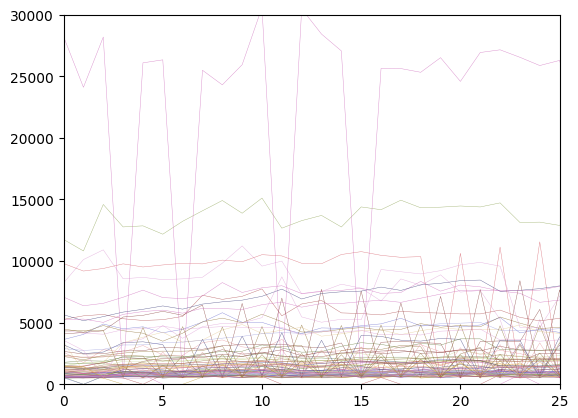

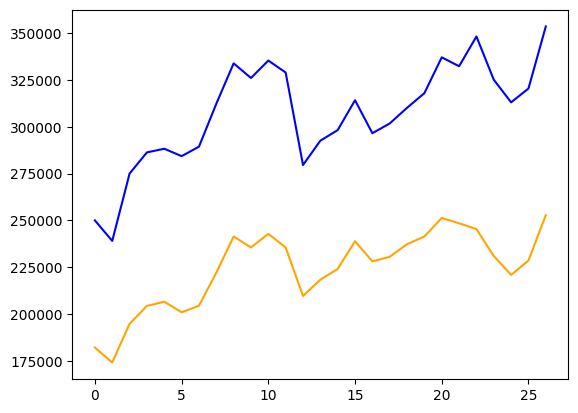

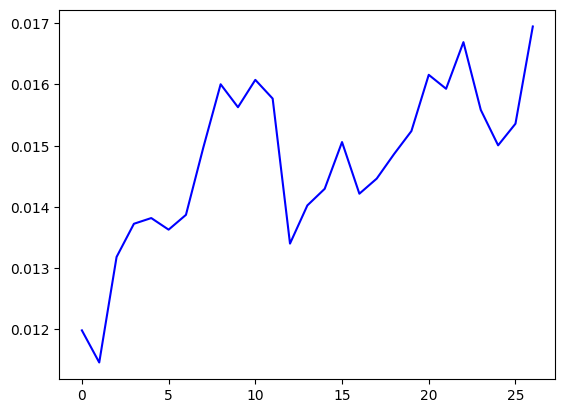

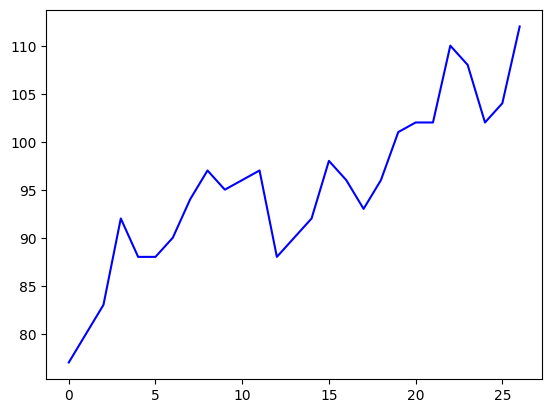

In [142]:
for c in sizes:
    plt.plot(sizes[c], label=c, color=tab20b_2(c), alpha=0.8, linewidth=0.3)
plt.axis([0, 25, 0, 30000])
plt.show()

plt.plot(total_lights, label='Total Lights', color='blue')
plt.plot(total_in_clusters, label='Total Lights in Clusters', color='orange')
plt.savefig("figures/total_lights.png", dpi=300, bbox_inches='tight')
plt.show()

plt.plot(percent_lights, label='Percent Lights', color='blue')
plt.savefig("figures/percent_lights.png", dpi=300, bbox_inches='tight')
plt.show()

plt.plot(num_clusters, label='Number of Clusters', color='blue')
plt.savefig("figures/num_clusters.png", dpi=300, bbox_inches='tight')   
plt.show()

In [123]:
gdp = pd.read_csv('./data/gdp.csv', skiprows=3, skipfooter=6)
msa_gdf = gpd.read_file('./data/msa.geojson')
msa_gdf

C:\Users\simon\AppData\Local\Temp\ipykernel_18540\689326400.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  gdp = pd.read_csv('./data/gdp.csv', skiprows=3, skipfooter=6)


,csafp,cbsafp,affgeoid,geoid,name,lsad,aland,awater,cartodb_id,created_at,updated_at,geometry
0,None,22380,310M200US22380,22380,"Flagstaff, AZ",M1,48222462009,109964003,132,2015-03-23 13:36:50+00:00,2015-03-23 13:36:50+00:00,"MULTIPOLYGON (((-113.35204 36.04753, -113.3486..."
1,438,38860,310M200US38860,38860,"Portland-South Portland, ME",M1,5386559509,2013596284,89,2015-03-23 13:36:50+00:00,2015-03-23 13:36:50+00:00,"MULTIPOLYGON (((-70.11817 43.68638, -70.11596 ..."
2,332,29420,310M200US29420,29420,"Lake Havasu City-Kingman, AZ",M1,34475300156,387348987,158,2015-03-23 13:36:50+00:00,2015-03-23 13:36:50+00:00,"MULTIPOLYGON (((-114.75562 36.08717, -114.7536..."
3,472,40900,310M200US40900,40900,"Sacramento-Roseville-Arden-Arcade, CA",M1,13194448617,549284977,96,2015-03-23 13:36:50+00:00,2015-03-23 13:36:50+00:00,"MULTIPOLYGON (((-122.40394 38.92529, -122.3547..."
4,206,44860,310M200US44860,44860,"Sulphur Springs, TX",M2,1987018485,66250918,104,2015-03-23 13:36:50+00:00,2015-03-23 13:36:50+00:00,"MULTIPOLYGON (((-95.8633 33.00012, -95.86178 3..."
...,...,...,...,...,...,...,...,...,...,...,...,...
924,515,35660,310M200US35660,35660,"Niles-Benton Harbor, MI",M1,1470458175,2625533770,924,2015-03-23 13:36:50+00:00,2015-03-23 13:36:50+00:00,"MULTIPOLYGON (((-86.82483 41.76024, -86.77723 ..."
925,None,26500,310M200US26500,26500,"Huntingdon, PA",M2,2265336839,37851926,925,2015-03-23 13:36:50+00:00,2015-03-23 13:36:50+00:00,"MULTIPOLYGON (((-78.25009 40.31229, -78.19105 ..."
926,154,15180,310M200US15180,15180,"Brownsville-Harlingen, TX",M1,2307835511,998174072,927,2015-03-23 13:36:50+00:00,2015-03-23 13:36:50+00:00,"MULTIPOLYGON (((-97.24085 26.4115, -97.22433 2..."
927,None,29340,310M200US29340,29340,"Lake Charles, LA",M1,6082764661,1767344418,928,2015-03-23 13:36:50+00:00,2015-03-23 13:36:50+00:00,"MULTIPOLYGON (((-93.92921 29.80295, -93.92799 ..."


In [128]:
from shapely.geometry import Point, MultiPolygon
from shapely.ops import nearest_points

poly_dict = {}

def find_nearest_multipolygon(point, multipolygons):
    """
    Finds the nearest multipolygon to a given point.

    Args:
        point: A shapely Point object.
        multipolygons: A list of shapely MultiPolygon objects.

    Returns:
        A tuple containing:
        - The nearest MultiPolygon object.
        - The distance to the nearest MultiPolygon.
    """
    nearest_poly = None
    min_distance = float('inf')

    for poly in multipolygons:
        distance = point.distance(poly)
        if distance < min_distance:
            min_distance = distance
            nearest_poly = poly

    poly_dict[point] = nearest_poly

In [ ]:
brightness_threshold = 50

x = []
y = []
msas = msa_gdf['geometry'].values

for year in [1992, 2018]:
    print(year)
    msa_gdf[f'num_points_{year}'] = 0

    with rasterio.open(f'./data/processed/US_{year}.tif') as src:
        night_lights = src.read(1)
        np.nan_to_num(night_lights, nan=0)
        transform = src.transform
        crs = src.crs

    threshold = 55
    binary_lights = (night_lights > threshold).astype(np.uint64)

    # Get pixel coordinates where light is above threshold
    y_indices, x_indices = np.where(binary_lights == 1)
    # Convert pixel indices to geographic coordinates
    xs, ys = rasterio.transform.xy(transform, y_indices, x_indices)

    for x, y in zip(xs, ys):
        point = Point(x, y)
        nearest_multipolygon = poly_dict.get(point, find_nearest_multipolygon(point, msas))
        msa_gdf.loc[msa_gdf['geometry'] == nearest_multipolygon, f'num_points_{year}'] += 1
msa_gdf     

Slope: -2.154341212945673e-18, Intercept: 1.8741839431277554


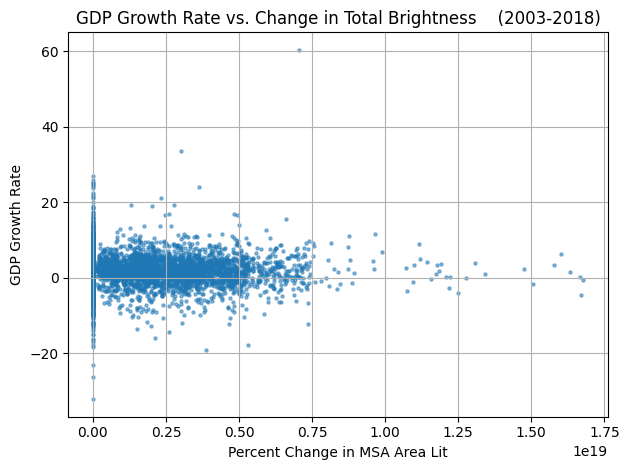

In [122]:
from scipy.stats import linregress

plt.scatter([100*x_ for x_ in x], y, alpha=0.5, s=5)
slope, intercept, r_value, p_value, std_err = linregress(x, y)
print(f"Slope: {slope}, Intercept: {intercept}")

# Create the regression line
x_fit = np.linspace(-100, 100, 1000)
y_fit = slope * x_fit + intercept

# Plot
plt.plot(x_fit, y_fit, color='red', label=f'Regression line')
plt.xlabel('Percent Change in MSA Area Lit')
plt.ylabel('GDP Growth Rate')
plt.title('GDP Growth Rate vs. Change in Total Brightness    (2003-2018)')
plt.grid(True)
# plt.axis([-10, 10, -20, 30])
plt.tight_layout()
plt.show()